# 프로그래밍 과제 1

**이 노트북을 완성하여 LMS로 제출한다. 작성한 코드의 실행결과를 지우지 말고 보존한 상태로 제출해야 한다.**

In [2]:
%matplotlib inline

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

10종류의 음식에 대해서 각각 1,000장의 이미지로 구성된 [데이터셋](https://drive.google.com/file/d/1rZ9DX4cDW7g0OGeFgkFKFzA_jZ1bzS93/view?usp=sharing)을 다운로드 받는다. 이 데이터셋은 torchvision이 제공하는 Food101 데이터셋에서 10종류의 음식만 선택해서 만든 것이다. 다운로드한 파일 `food10.zip`의 압축을 해제하면 `food10` 디렉토리의 내부에 두 개의 디렉토리 `train`과 `test`가 있고 각각에는 8,000과 2,000장의 음식 이미지가 들어있다. 이미지의 크기는 균일하지 않다. 

모든 이미지 파일의 이름은 0-9 사이의의 정수로 시작된다. 그 정수가 음식의 종류를 표시한다. 다음의 리스트 `classes`는 0-9번 까지의 음식 종류의 명칭이다. 예를 들어 `5_2871066.jpg`는 5로 시작하므로 나초(nachos)이다.

**주의:** 압축해제한 디렉토리 `food10`과 하위 디렉토리 `train` 및 `test`에 `.DS_Store`라는 이름의 숨김 파일이 있을 수 있다. 이 파일들은 모두 찾아내어 삭제해야 한다.

In [4]:
classes = ['donuts', 'french_fries', 'gyoza', 'hamburger', 'ice_cream', 'nachos', 'pizza', 'ramen', 'risotto', 'sushi']

Colab을 사용할 경우에는 `food10` 디렉토리를 자신의 Google Drive의 적절한 위치에 저장한다. PC에서 실행할할 경우에는 PC의 적절한 위치에 저장한다.

Colab을 사용할 경우 먼저 자신의 Google Drive를 다음과 같이 마운트한다. 이 작업은 로컬 PC에서는 불필요하다.

In [5]:
# from google.colab import drive
# drive.mount('/content/drive/')

import os

dir = os.listdir('.')
abspath = os.path.abspath(',')

print(dir)
print(abspath)

['download', 'food10.zip', 'food10', 'drive-download-20220927T080006Z-001', '.ipynb_checkpoints', 'data', 'datasets', '__MACOSX']
/notebooks/,


## Downloading dataset from Google Drive

Install `gdown` package

In [6]:
!pip install gdown

Use cached download and extract after

In [7]:
import gdown

url = 'https://drive.google.com/uc?id=1rZ9DX4cDW7g0OGeFgkFKFzA_jZ1bzS93'
output = 'food10.zip'
md5 = '4490d5d6a16cd56870c411a489f80b3e'

gdown.cached_download(url, output, md5=md5, quiet=False, postprocess=gdown.extractall)

Computing MD5: food10.zip
MD5 matches: food10.zip


'food10.zip'

Calculate downloaded file's checksum for later use

In [20]:
!md5sum food10.zip

4490d5d6a16cd56870c411a489f80b3e  food10.zip


데이터 디렉토리의 경로를 다음과 같이 설정한다. 각자 자신의 환경에 맞게 설정하면 된다.

In [8]:
# data_root = '/Users/taejongyoo/Library/CloudStorage/OneDrive-개인/부경대/강의/2022-2/딥러닝2/notebooks/datasets/food10' # local
data_root = '/notebooks/food10' # remote

_________________________________________________________________________

**문제 1:** 이미지의 크기를 균일하게 하고, 픽셀값을 적절하게 정규화하며, 또한 이미지와 라벨을 텐서(Tensor)로 변환하기 위한 데이터 전처리가 필요하다. `torchvision.transforms.Compose`를 이용하여 적절한 전처리 절차 `transform`을 정의하라. 이미지는 50*50 크기로 resizing하고, 각 채널의 픽셀값은 적절하게 정규화한다. 

In [9]:
transform = transforms.Compose([
    #  YOUR CODE HERE
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5432, 0.4355, 0.3316),
        (0.2576, 0.2510, 0.2530),
    ),
])

_________________________________________________________________________

**문제 2:** 데이터셋을 하나의 클래스 `FoodImageDataset`로 정의하라. 이 클래스를 이용하여 데이터셋을 생성할 때 training 데이터셋은 다음과 같이:

`trainset = FoodImageDataset(data_root, training=True, transform=transform)`

그리고, 테스트 데이터셋은 다음과 같이:

`testset = FoodImageDataset(data_root, training=False, transform=transform)`

생성할 수 있어야 한다. 즉, 매개변수수 `training`이 `True`인지 `False`인지에 따라서 구분하도록 구현하라.

In [10]:
from PIL import Image
from torchvision.io import read_image
import glob

class FoodImageDataset(Dataset):
    # YOUR CODE HERE
    # creating a custom dataset
    # https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    def __init__(self, training: bool, transform: torch.nn.Module):
        """
        Initializer function that runs once when creating a new instance of this dataset

        :param training: Boolean flag indicating whether this dataset will be used for training or for testing
        :type training: bool
        :param transform: Transformer module to preprocess the input samples before it is read
        :type transform: torch.nn.Module
        """
        self.training = training
        self.transform = transform
        self._dataset_root = os.path.join(data_root, "train" if self.training else "test")
        self._paths = []

    def _load_paths(self, force_reload: bool = True):
        # since the data sample hardly changes while using the dataset, and we need to
        # keep the ordering of files listed, it is better if we cache the whole file list
        if not force_reload or not self._paths:
            # list files in the directory; courtesy of https://stackoverflow.com/a/2632251
            # and https://stackoverflow.com/a/7099342/4592648
            # assume all files in the dataset directory are indeed correct and well-formed \
            # sample and no samples are added and removed during the usage of this dataset
            self._paths = [
                name
                for name in glob.glob(os.path.join(self._dataset_root, '*'))
                if os.path.isfile(os.path.join(self._dataset_root, name))
            ]

    def __len__(self) -> int:
        """
        Returns a number of samples in this dataset.

        :return: Number of samples in this dataset
        :rtype: int
        """
        self._load_paths()
        return len(self._paths)

    def _read_image(self, filename: str):
        return Image.open(os.path.join(self._dataset_root, filename))

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Loads and returns a sample for the given index in this dataset

        :param index: Index of the sample to fetch
        :type index: int
        :return: A sequence of single image sample and its target label
        :rtype: tuple[torch.Tensor, torch.Tensor]
        """
        self._load_paths()
        abspath = self._paths[index]
        filename = os.path.split(abspath)[1]
        image = self._read_image(abspath)
        # TODO: might be more efficient if we could mark the transforms' determinism and cache the results
        if self.transform:
            image = self.transform(image)
        label = int(filename.split("_")[0])
        return image, label


__________________________________________________________________

**문제 3:** 작성한 클래스 `FoodImageDataset`를 이용하여 두 개의 데이터셋 `trainset`, `testset`과 또한 각각에 대한 데이터 로더 `trainloader`, `testloader`를 생성하라. `trainloader`에서는 데이터를 shuffling하고, `testloader`에서는 shuffling하지 않는다. 배치 크기는 32로 한다.

In [11]:
batch_size = 32

In [12]:
# 여기에서 trainset, testset, trainloader, testloader를 생성한다.

trainset = FoodImageDataset(training=True, transform=transform)
testset = FoodImageDataset(training=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


### Calculate mean and std of dataset

From https://gist.github.com/JorritWillaert/2cae1da8cd42226a184f0268c0cb58f8

In [13]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [41]:
get_mean_and_std(trainloader)

(tensor([0.5432, 0.4355, 0.3316]), tensor([0.2576, 0.2510, 0.2530]))

_______________________________________________________________________________

아래의 함수 `imshow`는 하나의 Tensor 타입의 이미지를 받아서 화면에 디스플레이하는 함수이다. 이 함수는 픽셀 값들이 `-1.0~1.0` 사이의 실수로 정규화되어 있다고 가정하고 있다. 

In [14]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

아래의 코드를 실행하면 하나의 이미지가 디스플레이 되어야 한다. 또한 배치(batch)의 shape과 최대값, 최소값, 평균값 등이 올바른지 확인해보라.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


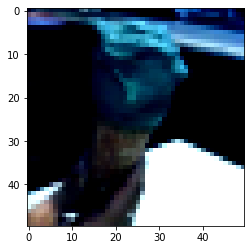

tensor(4)
torch.Size([32, 3, 50, 50])
torch.Size([32])
tensor(2.4249)
tensor(-2.0935)
tensor(-0.5596)


In [15]:
for img, label in trainloader:
    imshow(img[0])
    print(label[0])
    print(img.shape)
    print(label.shape)
    print(img[0].max())
    print(img[0].min())
    print(img[0].mean())
    break

실행할 디바이스를 선택한다.

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


**문제 4:** 3개의 컨볼루션 층을 가진 CNN을 하나의 클래스 Net으로 구현하라. 각각의 컨볼루션 층에서는 순서대로 16, 32, 32개의 크기가 3인 필터를 적용하라. `stride`나 `padding` 등의 나머지 선택사항들은 `nn.Conv2d`의 디폴트 설정을 그대로 따른다. 각각의 컨볼루션 층 다음에는 MaxPooling 층과 ReLu 활성화 함수를 적용하라. 마지막 컨볼루션 층의 출력에 Flatten 층을 적용한 후 적절한 크기의 3개의 Linear 층을 거쳐서 최종 출력이 나오도록 만들어라.

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) # in, out, ksize
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2) # ksize, stride
        self.pool3 = nn.MaxPool2d(3, 3) # ksize, stride
        self.fc1 = nn.Linear(32*3*3, 128) # in, out
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool2(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        # input image: 3 channel RGB image of size 50x50
        # ksize: 3, stride = 1(default), padding = 0(default)
        # conv1: (3,50,50)->(16,48,48)
        # pool2: (16,48,48)->(16,24,24)
        # conv2: (16,24,24)->(32,22,22)
        # pool2: (32,22,22)->(32,11,11)
        # conv3: (32,11,11)->(32,9,9)
        # pool3: (32,9,9)->(32,3,3)
        x = torch.flatten(x, 1) # batch를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


 직성한 클래스 `Net`을 이용하여 네트워크를 생성하고 디바이스에 할당한다.

In [18]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

_______________________________________________________________________________

손실함수와 옵티마이저를 다음과 같이 정의한다.

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

__________________________________________________________________________

**문제 5:** 한 에포크(epoch)의 트레이닝을 수행하는 함수 `train`을 작성하라. 한 에포크 동안의 평균 손실(loss)을 계산하여 출력하도록 구현하라.

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    # YOUR CODE HERE
    model.train()

    loss_values = []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y) # pred is tensor while y is scalar, in this case pytorch automatically one-hot encodes the scalar into a tensor

        # 역전파
        optimizer.zero_grad() # 수동으로 gradient 초기화
        loss.backward() # 역전파. 레이어 별 chain rule 적용
        optimizer.step()

        # record loss
        loss_values.append(loss.item())
    print(f'Average loss: {torch.mean(torch.FloatTensor(loss_values))}')


____________________________________________________________________________

**문제 6:** 모든 테스트 데이터를 한 번 사용하여 테스트를 수행하는 함수 `test`를 작성하라. 정확도(accuracy)를 계산하여 출력하도록 구현하라. 

In [21]:
def test(dataloader, model, loss_fn):
    # YOUR CODE HERE
    model.eval()

    test_loss, correct = 0, 0
    with torch.no_grad(): # create a new context where grad is not evaluated automatically
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # pred.argmax(<axis index>) -> returns array of indices of each subarrays' max value
            # pred.argmax(...) == y -> implicit type conversion [true, false, ...]
            # .type(torch.float) -> converts to tensor true = 1, false = 0
            # .sum() adds correct count
            # .item() unwrap underlying value from tensor

    num_batches = len(dataloader)
    test_loss /= num_batches
    size = len(dataloader.dataset)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


_______________________________________________________________________

아래의 코드는 20 에포크(epoch) 동안 training을 수행한다. 매 epoch마다 평균 손실(loss)이  출력된다. 또한 매 epoch마다 테스트 데이터셋에 속한 모든 이미지를 사용하여 테스트를 수행하고 예측의 정확도를 계산하여 출력한다. 

In [22]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, criterion, optimizer)
    test(testloader, net, criterion)
print("Done!")

Epoch 1
-------------------------------
Average loss: 2.3044896125793457
Test Error: 
 Accuracy: 10.1%, Avg loss: 2.303269 

Epoch 2
-------------------------------
Average loss: 2.3028504848480225
Test Error: 
 Accuracy: 11.9%, Avg loss: 2.302028 

Epoch 3
-------------------------------
Average loss: 2.301818609237671
Test Error: 
 Accuracy: 15.4%, Avg loss: 2.301039 

Epoch 4
-------------------------------
Average loss: 2.3008639812469482
Test Error: 
 Accuracy: 15.0%, Avg loss: 2.300013 

Epoch 5
-------------------------------
Average loss: 2.299743413925171
Test Error: 
 Accuracy: 16.0%, Avg loss: 2.298646 

Epoch 6
-------------------------------
Average loss: 2.298100471496582
Test Error: 
 Accuracy: 17.1%, Avg loss: 2.296457 

Epoch 7
-------------------------------
Average loss: 2.295170307159424
Test Error: 
 Accuracy: 17.7%, Avg loss: 2.292363 

Epoch 8
-------------------------------
Average loss: 2.2892885208129883
Test Error: 
 Accuracy: 17.8%, Avg loss: 2.283796 

Epoc

___________________________________________________________

**문제 7:** 한 개의 numpy array로 표현된 3채널 이미지와 위에서 학습한 네트워크 모델 net을 입력으로 받아서 음식의 종류를 판정하여 음식 이름과 추정확률을 출력하는 함수 `eval`을 작성하라. 이미지의 사이즈는 50*50이다. `nn.Softmax` 모듈을 이용하라.

In [23]:
# Softmax 층을 생성한다. 이것을 함수 eval 내부에서 사용하라.
sm = nn.Softmax(dim=1)

# 매개변수 model은 트레이닝된 네트워크 모델이며, img는 50*50*3 크기의 numpy array이며
# 배열에 저장된 값은 0~255 사이의 정수이다.

print(device)

def eval(model, img):
    # YOUR CODE HERE
    model.eval()
    with torch.no_grad():
        img = torch.FloatTensor(img).transpose(0, 2).unsqueeze(0)
        model = model.to(device)
        img = img.to(device)

        pred = model(img)
        max = sm(pred)
        prob, index = max.max(1)
        print(f"{classes[int(index)]} with probability {prob.item()}")

# TODO: need to include fake images in training data




cuda:0


아래의 코드를 실행하면 예를 들어 다음과 같이 음식 이름과 추정 확률이 출력되어야 한다:

    `ice_cream with probability 0.20791929960250854`


In [35]:
fakeimg = np.random.randint(256, size=(50, 50, 3))
eval(net, fakeimg)

ice_cream with probability 1.0
